In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn as nn
import csv
import pandas as pd
from keras.callbacks import History
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout,Input
# import tensorflow as tf
# print(tf.__file__)
from pandas import read_csv
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["axes.unicode_minus"]=False


In [2]:
def generate_diff(input_array):
    output_array = [0]  #initialize
    
    for i in range(1, len(input_array)):
        output_array.append(input_array[i] - input_array[i - 1])
        
    return output_array
    
# load data
def parse(x):
    return datetime.strptime(x, '%Y/%m/%d')

dataset = read_csv('2012-2016.csv')
dataset['DateTime'] = pd.to_datetime(dataset['Date'] + ' ' + dataset['Time'])



# # Time format
# dataset['Time'] = pd.to_datetime(dataset['Time'])

# #Time select
# start_time = pd.to_datetime("8:44:00").time()
# end_time = pd.to_datetime("10:30:10").time()
# selected_data = dataset[(dataset['Time'].dt.time >= start_time) & (dataset['Time'].dt.time <= end_time)]
selected_data=dataset


###### 每天第一筆資料diff設為0
#selected_data.loc[dataset['Date'] != dataset['Date'].shift(), ['Diff','Diff_Pct']] = 0

#######
selected_data.set_index('DateTime', inplace=True)
selected_data.drop(columns=['Time','Date'], inplace=True)

selected_data=selected_data.dropna()
# summarize first 5 rows
# print(selected_data.head(5))

df_resampled = selected_data.resample('10T').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'TotalVolume': 'sum',
})
df_resampled['Diff_Pct'] = df_resampled['Close'].pct_change()
df_resampled['Diff'] = df_resampled['Close'].diff()
df_resampled["C-L"] = df_resampled["Close"] - df_resampled["Low"]
df_resampled["H-L"] = df_resampled["High"] - df_resampled["Low"]
df_resampled["%K"] = (df_resampled["C-L"] / df_resampled["H-L"]) * 100
# %D 三週期MA
df_resampled["%D"] = df_resampled["%K"].rolling(window=3).mean()

# RSI
df_resampled['Gain'] = df_resampled['Diff'].apply(lambda x: x if x > 0 else 0)
df_resampled['Loss'] = df_resampled['Diff'].apply(lambda x: -x if x < 0 else 0)

# 平均上漲下跌變化 (14天)
window = 14
df_resampled['AvgGain'] = df_resampled['Gain'].rolling(window=window).mean()
df_resampled['AvgLoss'] = df_resampled['Loss'].rolling(window=window).mean()
# 计算相对强度（RS）
df_resampled['RS'] = df_resampled['AvgGain'] / df_resampled['AvgLoss']
# 计算RSI
df_resampled['RSI'] = 100 - (100 / (1 + df_resampled['RS']))
df_resampled.drop(columns=['RS','AvgLoss','AvgGain','Gain', 'Loss'], inplace=True)

############
# 布林通道
df_resampled['SMA'] = df_resampled['Close'].rolling(window=20).mean()
df_resampled['StdDev'] = df_resampled['Close'].rolling(window=20).std()
df_resampled['UpperBand'] = df_resampled['SMA'] + (2 * df_resampled['StdDev'])
df_resampled['LowerBand'] = df_resampled['SMA'] - (2 * df_resampled['StdDev'])
###########

# drop NaN
df_resampled = df_resampled.dropna()
print(df_resampled[:6])


# # save to file


                       Open    High     Low   Close  TotalVolume  Diff_Pct  \
DateTime                                                                     
2012-01-02 11:50:00  6947.0  6959.0  6946.0  6956.0         1238  0.001296   
2012-01-02 12:00:00  6958.0  6962.0  6956.0  6956.0         1162  0.000000   
2012-01-02 12:10:00  6956.0  6959.0  6951.0  6956.0         1150  0.000000   
2012-01-02 12:20:00  6956.0  6960.0  6954.0  6955.0          597 -0.000144   
2012-01-02 12:30:00  6955.0  6972.0  6955.0  6964.0         2408  0.001294   
2012-01-02 12:40:00  6965.0  6968.0  6950.0  6955.0         1917 -0.001292   

                     Diff   C-L   H-L         %K         %D        RSI  \
DateTime                                                                 
2012-01-02 11:50:00   9.0  10.0  13.0  76.923077  52.307692  14.432990   
2012-01-02 12:00:00   0.0   0.0   6.0   0.000000  30.085470  11.702128   
2012-01-02 12:10:00   0.0   5.0   8.0  62.500000  46.474359  12.643678   
2012-

In [4]:
def generate_y_for10(input_array):
    output_array = [] 
    
    for i in range(0, len(input_array)):
        if input_array[i]>0:
            output_array.append(2)
        elif input_array[i]<0:
            output_array.append(1)
        else:
            output_array.append(0)
    
    return output_array

def generate_y(input_array):
    output_array = []  # initialize
    
    for i in range(0, len(input_array)-1):
        output_array.append(input_array[i+1] - input_array[i])
        
    return output_array
    

values = df_resampled.values
# ensure all data is float
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0,1))
#############################################
# scaler_diff=MinMaxScaler(feature_range=(-1,1))
# t=scaler_diff.fit_transform(values[:,-1].reshape(-1,1))
# print(t)
#############################################
# normalize features
scaled = scaler.fit_transform(values)
print(scaled)

# ##漲跌平
class_indices= generate_y_for10(values[:,5]) #diff
# 确定类别的数量
num_classes = max(class_indices) + 1


y_label = np.zeros((len(class_indices), num_classes))
#2類別對應位置set 1
y_label[np.arange(len(class_indices)), class_indices] = 1
# y_label=generate_y(values[:,3])#close明天相對今天增長量
print(y_label[:5])
# ##

# # 新增一列(diff 正規過後)
# # diff_n= np.array(generate_diff(scaled[:,3]))#close
# diff_n=
# #布爾掩碼
# mask = values[:,5] == 0.0
# # 
# diff_n[mask] = 0.0
# x_label=np.hstack((scaled[:,[0,1,2,3,4,6,7]], diff_n.reshape(-1, 1)))
###########################
x_label=scaled[:,[0,1,2,3,5,7,8,9,10,11]]
# print(scaled[:5])
print(x_label[208:215])

[[0.03487277 0.03496075 0.03581524 ... 0.17494844 0.06160522 0.04616737]
 [0.03832865 0.0359056  0.03895712 ... 0.18072946 0.0613277  0.04460788]
 [0.03770041 0.03496075 0.03738618 ... 0.17647846 0.0595119  0.04375935]
 ...
 [0.7618599  0.7622049  0.76280236 ... 0.04131111 0.75685835 0.762584  ]
 [0.76280236 0.761575   0.76280236 ... 0.03378462 0.7564206  0.76382446]
 [0.7621741  0.7609451  0.76280236 ... 0.03023331 0.75631976 0.7645147 ]]
[[0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[0.2507069  0.25007892 0.25164938 0.2531407  0.5558203  0.08510638
  0.07079646 0.88888884 0.45502648 0.5391997 ]
 [0.25322032 0.25039387 0.24913621 0.24874377 0.43380296 0.0212766
  0.15044248 0.1111111  0.38095236 0.5174877 ]
 [0.24850774 0.24692917 0.2478795  0.24905777 0.5169751  0.07446808
  0.08849557 0.6363636  0.54545456 0.59478414]
 [0.24850774 0.24944901 0.24976444 0.25251245 0.5725101  0.12765957
  0.10619469 0.9230769  0.55685055 0.6009281 ]
 [0.25196362 0.25228357 0.25227785 0

In [5]:
# values = selected_data.values
# # ensure all data is float
# values = values.astype('float32')
# scaler = MinMaxScaler(feature_range=(0,1)).fit(values)
# x_label=scaled=scaler.transform(values)
# print(x_label[:5])
# y_label=[x[5] for x in scaled]
# y_label = y_label[1:]
# print(y_label[:5])
# print(y_label[0])

# qq=np.zeros((len(y_label),8))
# qq[:,5]=np.array(y_label)
# print(qq)
# qqq=scaler.inverse_transform(qq)
# print(qqq[0,5])

In [6]:
def split_windows(data,label, seq_length):
    x=[]
    y=[]
    for i in range(len(data)-seq_length-1):
        _x=data[i:(i+seq_length),:]
        _y=label[i+seq_length]
        x.append(_x)
        y.append(_y)
    x,y=np.array(x),np.array(y)
    # print('x.shape,y.shape=\n',x.shape,y.shape)
    return x,y

def split_data(x, y, split_ratio):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=split_ratio, shuffle=False)
    return x_train, y_train, x_test, y_test



In [7]:
windowed_x, windowed_y = split_windows(x_label, y_label, 6) ##特徵序列長度#middle
print(windowed_x.shape, windowed_y.shape)

(14717, 6, 10) (14717, 3)


In [8]:
x_train, y_train, x_test, y_test = split_data(windowed_x, windowed_y, 0.2)#數據集分割 #paper test為2016年, 大概20%?
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(11773, 6, 10) (11773, 3)
(2944, 6, 10) (2944, 3)


In [16]:
model=Sequential()
model.add(LSTM(32, input_shape=(x_train.shape[1], x_train.shape[2]),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, input_shape=(x_train.shape[1],32),return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu',kernel_initializer='normal'))
model.add(Dense(3, activation='softmax', kernel_initializer='normal'))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

history=model.fit(x_train, y_train, epochs=150, validation_data=(x_test, y_test), batch_size=300, verbose=1)

Epoch 1/150
40/40 [==============================] - 10s 50ms/step - loss: 1.0192 - accuracy: 0.4412 - val_loss: 0.9356 - val_accuracy: 0.4674
Epoch 2/150
40/40 [==============================] - 1s 14ms/step - loss: 0.9389 - accuracy: 0.4558 - val_loss: 0.9252 - val_accuracy: 0.4674
Epoch 3/150
40/40 [==============================] - 1s 14ms/step - loss: 0.9350 - accuracy: 0.4600 - val_loss: 0.9253 - val_accuracy: 0.4674
Epoch 4/150
40/40 [==============================] - 1s 14ms/step - loss: 0.9355 - accuracy: 0.4575 - val_loss: 0.9252 - val_accuracy: 0.4674
Epoch 5/150
40/40 [==============================] - 1s 14ms/step - loss: 0.9349 - accuracy: 0.4539 - val_loss: 0.9251 - val_accuracy: 0.4674
Epoch 6/150
40/40 [==============================] - 1s 14ms/step - loss: 0.9355 - accuracy: 0.4605 - val_loss: 0.9252 - val_accuracy: 0.4477
Epoch 7/150
40/40 [==============================] - 1s 13ms/step - loss: 0.9349 - accuracy: 0.4633 - val_loss: 0.9255 - val_accuracy: 0.4674
Epoch

In [17]:
model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 6, 32)             5504      
                                                                 
 dropout_2 (Dropout)         (None, 6, 32)             0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 14979 (58.51 KB)
Trainable params: 14979

In [18]:
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

92/92 [==============================] - 0s 5ms/step


In [19]:

# print(train_predict.shape)
# tr_predict=np.zeros((train_predict.shape[0], 8))
# te_predict=np.zeros((test_predict.shape[0], 8))

# tr_predict[:,5]=train_predict.squeeze()
# te_predict[:,5]=test_predict.squeeze()
# print(tr_predict[0])
# print(tr_predict.shape,te_predict.shape)

# tr_predict=scaler.inverse_transform(tr_predict)
# tr_predict=[x[5] for x in tr_predict]


# te_predict=scaler.inverse_transform(te_predict)
# te_predict=[x[5] for x in te_predict]
# # print(te_predict)

# print(tr_predict[:5])
# print(te_predict[:5])

In [20]:
# def custom_accuracy(array1, array2):
#     total_elements = len(array1)
#     correct_matches = 0

#     for val1, val2 in zip(array1, array2):
#         if (val1 > 0 and val2 > 0) or (val1 < 0 and val2 < 0):
#             correct_matches += 1
#         elif val1 == 0 and val2 == 0:
#             correct_matches += 1

#     accuracy = correct_matches / total_elements
#     return accuracy

# # for i in tr_predict:
# #     if i <=0 :
# #         print('y')
# yT=np.zeros((y_train.shape[0], 8))
# yT[:,5]=y_train.squeeze()
# yT=scaler.inverse_transform(yT)
# yT=[x[5] for x in yT]

# yt=np.zeros((y_test.shape[0], 8))
# yt[:,5]=y_test.squeeze()
# yt=scaler.inverse_transform(yt)
# yt=[x[5] for x in yt]

# print(custom_accuracy(tr_predict,yT))
# print(custom_accuracy(te_predict,yt))
# print(tr_predict[:5], y_train[:5])


In [21]:



    
test_predict_argmax = np.argmax(test_predict, axis=1)
y_test_argmax = np.argmax(y_test, axis=1)
# accuracy
accuracy = np.mean(y_test_argmax == test_predict_argmax)
print("Accuracy test:", accuracy)

np.save('10_test.npy', test_predict_argmax)

train_predict_argmax = np.argmax(train_predict, axis=1)
y_train_argmax = np.argmax(y_train, axis=1)
# accuracy
accuracy = np.mean(y_train_argmax == train_predict_argmax)
print("Accuracy train:", accuracy)

np.save('10_train.npy', train_predict_argmax)


idx_l=[]
for idx, value in enumerate(train_predict_argmax):
    if value == 0:
        idx_l.append(idx)

# print(idx_l)
idx_ll=[]
for idx, value in enumerate(y_test_argmax):
    if value == 0:
        idx_ll.append(idx)

print(len(idx_l),len(idx_ll))
print(len(y_test_argmax))

##drop 0.2 兩次 step=6 RSI 8:30~10:30
# Accuracy test: 0.4788966691167937
# Accuracy train: 0.47840300210843956
#全時段
# Accuracy test: 0.4549774716169764
# Accuracy train: 0.45354446631858253


Accuracy test: 0.47452445652173914
Accuracy train: 0.4710778900874883
0 250
2944


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


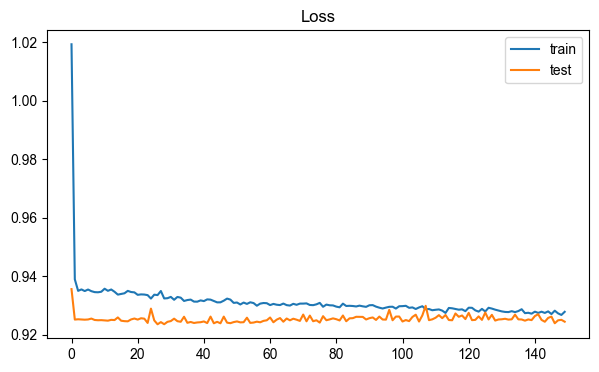

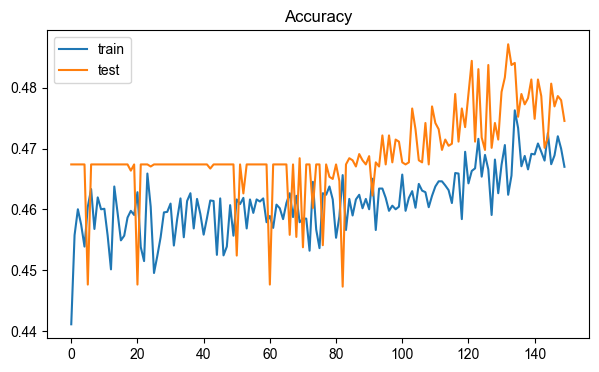

In [23]:
print(history.history.keys())
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial']  
plt.rcParams['axes.unicode_minus'] = False 
# plot history
plt.figure(figsize=(7, 4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("Loss")
plt.show()

# plot history
plt.figure(figsize=(7, 4))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.title("Accuracy")
plt.show()


